In [616]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [617]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [618]:
import csv

In [619]:
data = []
atributes = []
labels = []

with open('testData.csv', 'r', newline='') as file:
    reader = csv.reader(file)
    for index, line in enumerate(reader):
        if index == 0:
            atributes = line
        else:
            if (line[0] not in labels):
                labels.append(line[0])
            data.append(line)


In [620]:
data_types = []

def determine_type(value):
    try:
        float(value)
        return 'Float'
    except ValueError:
        return 'Nominal'

In [621]:
for value in data[0]:
    data_types.append(determine_type(value))

if data_types[0] == 'Float':
    unique_values = list(set(data[0]))
    print(unique_values)


['Male', '22', '3', '1', '0', '7.25']


In [622]:
for index, type in enumerate(data_types):
    if (type == 'Nominal'):
        unique_values = list(set(row[index] for row in data))
        if index == 0:
            labels = [str(unique_values.index(label)) for label in labels]
        for row in data:
            row[index] = str(unique_values.index(row[index]))

In [623]:
y = []
X = []
for line in data:
    y.append(labels.index(line[0]))
    X.append([float(s) for s in line[1:]])

In [624]:
y = torch.tensor(y)
X = torch.tensor(X)

In [625]:
RANDOM_SEED = 42

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [626]:
X_tr = X_tr.to(device)
X_te = X_te.to(device)
y_tr = y_tr.to(device)
y_te = y_te.to(device)

In [627]:
X_tr[0]

tensor([  1.0000,   0.0000,  22.0000,   0.0000,   0.0000, 151.5500,   3.0000],
       device='cuda:0')

In [628]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=len(X_tr[0]), out_features=10),
            nn.BatchNorm1d(10),
            nn.ReLU(),
            nn.Dropout(p=0.02),
            nn.Linear(in_features=10, out_features=len(labels)),
        )

    def forward(self, x):
        return self.layer_stack(x)


In [629]:
model = Model().to(device)
model

Model(
  (layer_stack): Sequential(
    (0): Linear(in_features=7, out_features=10, bias=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.02, inplace=False)
    (4): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [630]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [631]:
def accuracy_fn(y_pred, y_target):
    correct = torch.eq(y_pred, y_target).sum().item()

    return (correct/len(y_pred))*100

In [632]:
torch.manual_seed(42)

i_count = []
train_loss_values, test_loss_values = [], []
iterations = 200


for i in range(iterations):
    model.train()

    logits = model(X_tr)
    logits_pred = torch.softmax(logits, dim=1).argmax(dim=1)

    acc = accuracy_fn(y_target=y_tr, y_pred=logits_pred)
    loss = loss_fn(logits, y_tr)
    train_loss_values.append(loss.item())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    i_count.append(i)

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_te)
        test_logits_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_te)
        test_loss_values.append(test_loss.item())
        test_acc = accuracy_fn(y_target=y_te, y_pred=test_logits_pred)

    if (i) % 20 == 0:
        print(f'Iteration {i}: TRAIN LOSS: {loss:.5f} | TRAIN ACCURACY: {acc:.1f}% | TEST_LOSS: {test_loss:.5f} | TEST ACCURACY: {test_acc:.1f}%')

print(f'Iteration {i+1}: TRAIN LOSS: {loss:.5f} | TRAIN ACCURACY: {acc:.2f}% | TEST_LOSS: {test_loss:.5f} | TEST ACCURACY: {test_acc:.2f}%')

Iteration 0: TRAIN LOSS: 0.71329 | TRAIN ACCURACY: 38.5% | TEST_LOSS: 0.71472 | TEST ACCURACY: 64.6%
Iteration 20: TRAIN LOSS: 0.64535 | TRAIN ACCURACY: 66.5% | TEST_LOSS: 0.62153 | TEST ACCURACY: 70.8%
Iteration 40: TRAIN LOSS: 0.59508 | TRAIN ACCURACY: 74.1% | TEST_LOSS: 0.60318 | TEST ACCURACY: 72.5%


Iteration 60: TRAIN LOSS: 0.54728 | TRAIN ACCURACY: 75.5% | TEST_LOSS: 0.55013 | TEST ACCURACY: 75.3%
Iteration 80: TRAIN LOSS: 0.49722 | TRAIN ACCURACY: 79.5% | TEST_LOSS: 0.48621 | TEST ACCURACY: 77.0%
Iteration 100: TRAIN LOSS: 0.45230 | TRAIN ACCURACY: 79.2% | TEST_LOSS: 0.45468 | TEST ACCURACY: 78.7%
Iteration 120: TRAIN LOSS: 0.43301 | TRAIN ACCURACY: 80.9% | TEST_LOSS: 0.43882 | TEST ACCURACY: 80.3%
Iteration 140: TRAIN LOSS: 0.42111 | TRAIN ACCURACY: 81.4% | TEST_LOSS: 0.44231 | TEST ACCURACY: 79.2%
Iteration 160: TRAIN LOSS: 0.41453 | TRAIN ACCURACY: 81.3% | TEST_LOSS: 0.44798 | TEST ACCURACY: 79.8%
Iteration 180: TRAIN LOSS: 0.41170 | TRAIN ACCURACY: 81.7% | TEST_LOSS: 0.44618 | TEST ACCURACY: 80.3%
Iteration 200: TRAIN LOSS: 0.40783 | TRAIN ACCURACY: 82.00% | TEST_LOSS: 0.44306 | TEST ACCURACY: 82.58%


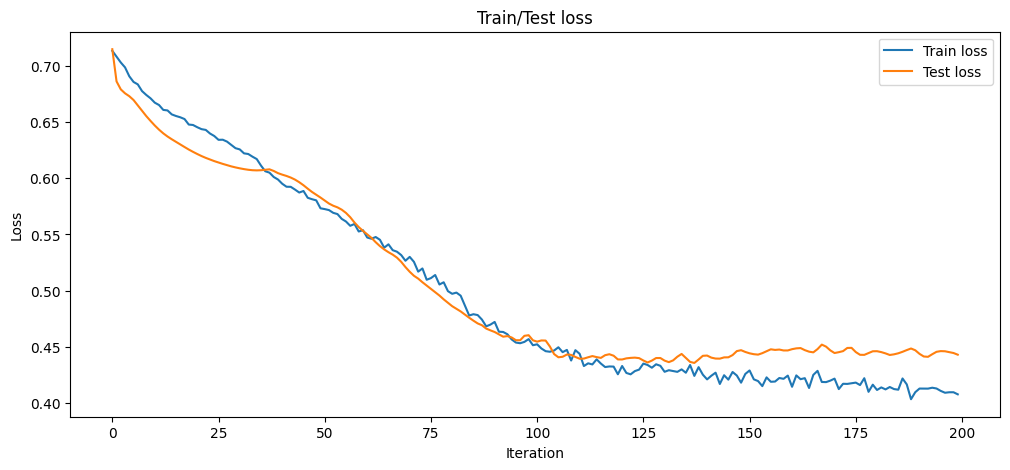

In [633]:
plt.figure(figsize=(12,5))
plt.plot(i_count, train_loss_values, label='Train loss')
plt.plot(i_count, test_loss_values, label='Test loss')
plt.title("Train/Test loss")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.legend()